## Transfer Learning in HuggingFace with PyTorch: 
* **Train only only n last layers from the pretrained model, freezing rest of the weights**
* **And, add one trainable linear layer at the end of this pretrained model**

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.datasets import fetch_20newsgroups

from transformers import BertForSequenceClassification, BertTokenizer, BertModel

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score

import torch
from torch import nn

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

### References:
* **https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f**
* **https://huggingface.co/transformers/v3.3.1/training.html#pytorch**
* **https://towardsdatascience.com/bert-text-classification-using-pytorch-723dfb8b6b5b**
* **https://blog.insightdatascience.com/using-transfer-learning-for-nlp-with-small-data-71e10baf99a6**

### BERT Classification Arch:

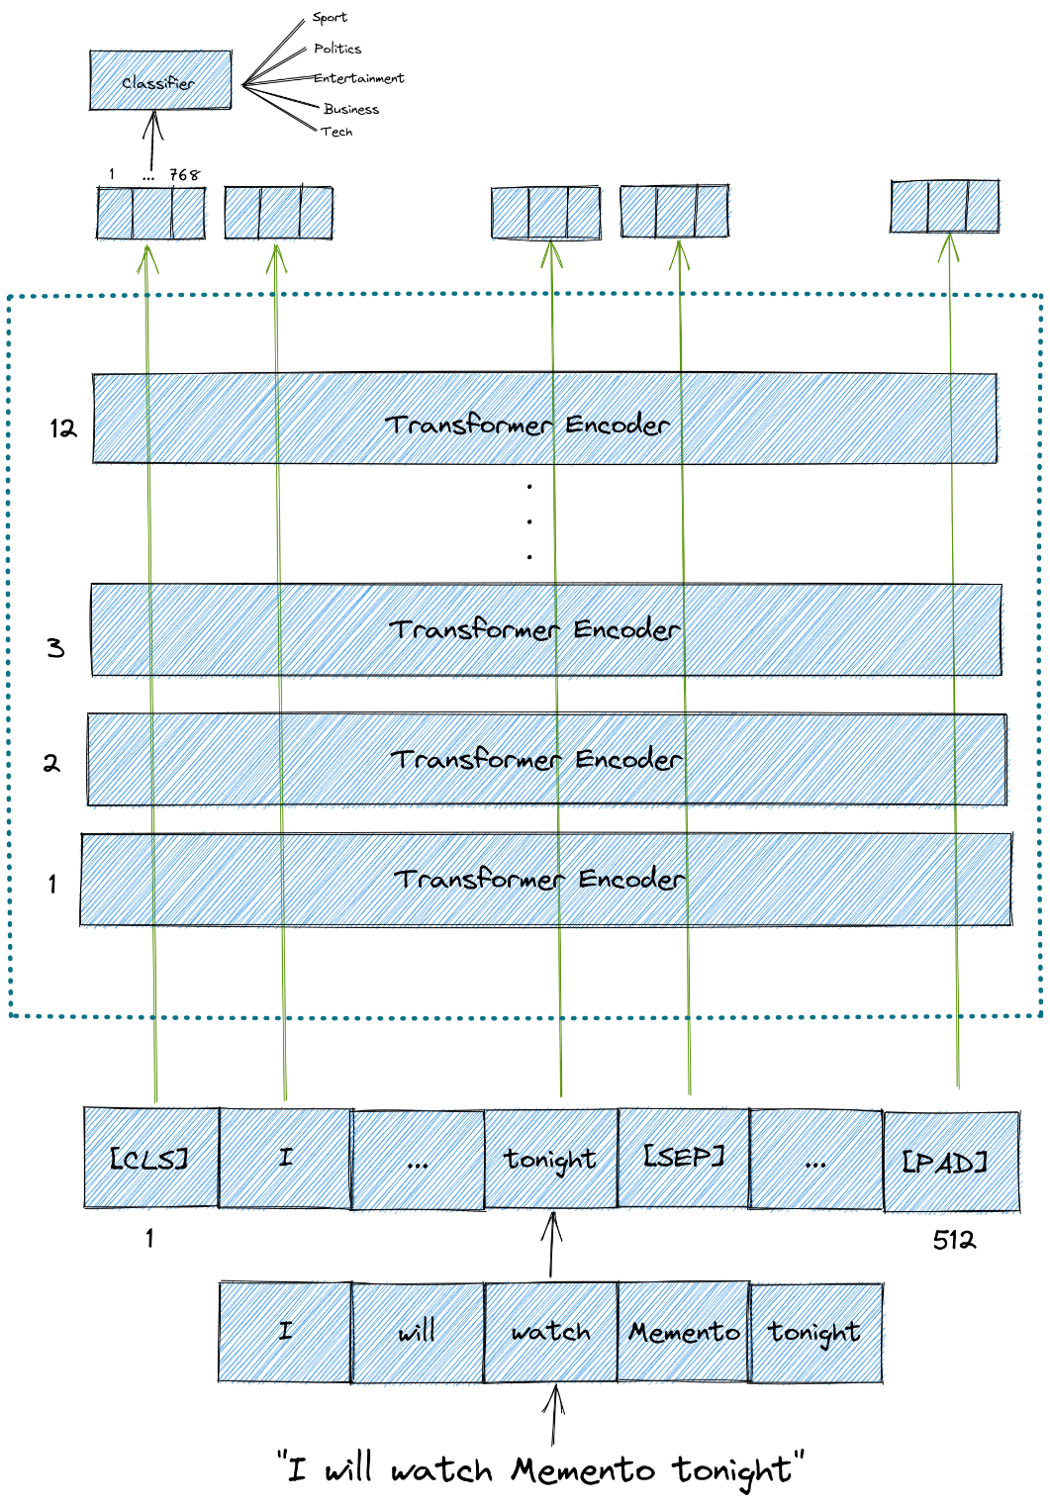

In [3]:
pd.options.display.max_rows=100
pd.options.display.max_columns=100

In [4]:
model = BertModel.from_pretrained('google/bert_uncased_L-2_H-128_A-2')
## it's a TineyBERT model

Downloading:   0%|          | 0.00/382 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### VERY IMPORTANT ###
* **NOTE: If I use BertForSequenceClassification, then I would not have to add any linear or any sigmoid layer at the end to do the classification task.I can directly use this model to predict the classes.** 
* **We are using BERTModel, since we want to customize our linear layers at the end to have trainable layers after the pooling layer**
* **Different size of BERT models: https://huggingface.co/google/bert_uncased_L-4_H-512_A-8**

In [5]:
tokenizer = BertTokenizer.from_pretrained('google/bert_uncased_L-2_H-128_A-2', do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [6]:
model.named_parameters

<bound method Module.named_parameters of BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 128, padding_idx=0)
    (position_embeddings): Embedding(512, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=128, out_features=128, bias=True)
            (key): Linear(in_features=128, out_features=128, bias=True)
            (value): Linear(in_features=128, out_features=128, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=128, out_features=128, bias=True)
            (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
            (dropout):

In [7]:
count=0
for name, param in model.named_parameters():
    print(name)
    count+=1

embeddings.word_embeddings.weight
embeddings.position_embeddings.weight
embeddings.token_type_embeddings.weight
embeddings.LayerNorm.weight
embeddings.LayerNorm.bias
encoder.layer.0.attention.self.query.weight
encoder.layer.0.attention.self.query.bias
encoder.layer.0.attention.self.key.weight
encoder.layer.0.attention.self.key.bias
encoder.layer.0.attention.self.value.weight
encoder.layer.0.attention.self.value.bias
encoder.layer.0.attention.output.dense.weight
encoder.layer.0.attention.output.dense.bias
encoder.layer.0.attention.output.LayerNorm.weight
encoder.layer.0.attention.output.LayerNorm.bias
encoder.layer.0.intermediate.dense.weight
encoder.layer.0.intermediate.dense.bias
encoder.layer.0.output.dense.weight
encoder.layer.0.output.dense.bias
encoder.layer.0.output.LayerNorm.weight
encoder.layer.0.output.LayerNorm.bias
encoder.layer.1.attention.self.query.weight
encoder.layer.1.attention.self.query.bias
encoder.layer.1.attention.self.key.weight
encoder.layer.1.attention.self.key

In [8]:
count

39

### Transfer Learning - Freezing the encoding layers and keeping only last 2 layers (weight & bias) for training

In [9]:

## Training only last 2 params of the last classifier layer - weight & bias.
## Rest are frozen
## Freezing the weights of the layers so that training doesn't happen on these layers:

for name in list(model.named_parameters())[:-2]:
    param.requires_grad=False
    #print(name)

In [10]:
tokenizer

PreTrainedTokenizer(name_or_path='google/bert_uncased_L-2_H-128_A-2', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

### Sklearn dataset

In [11]:
dataset = fetch_20newsgroups(subset="all", shuffle=True, remove=("headers", "footers", "quotes"))

In [12]:
len(dataset.data)

18846

In [13]:
## Taking only small data for this task
X=dataset.data[0:5000]
Y=dataset.target[0:5000]

In [14]:
set(Y)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

In [15]:
len(set(Y))

20

In [16]:
trainx, validx, trainy, validy=train_test_split(X, Y, test_size=.2, stratify=Y)

In [17]:
len(trainx)

4000

### Working of BERTTokenizer:

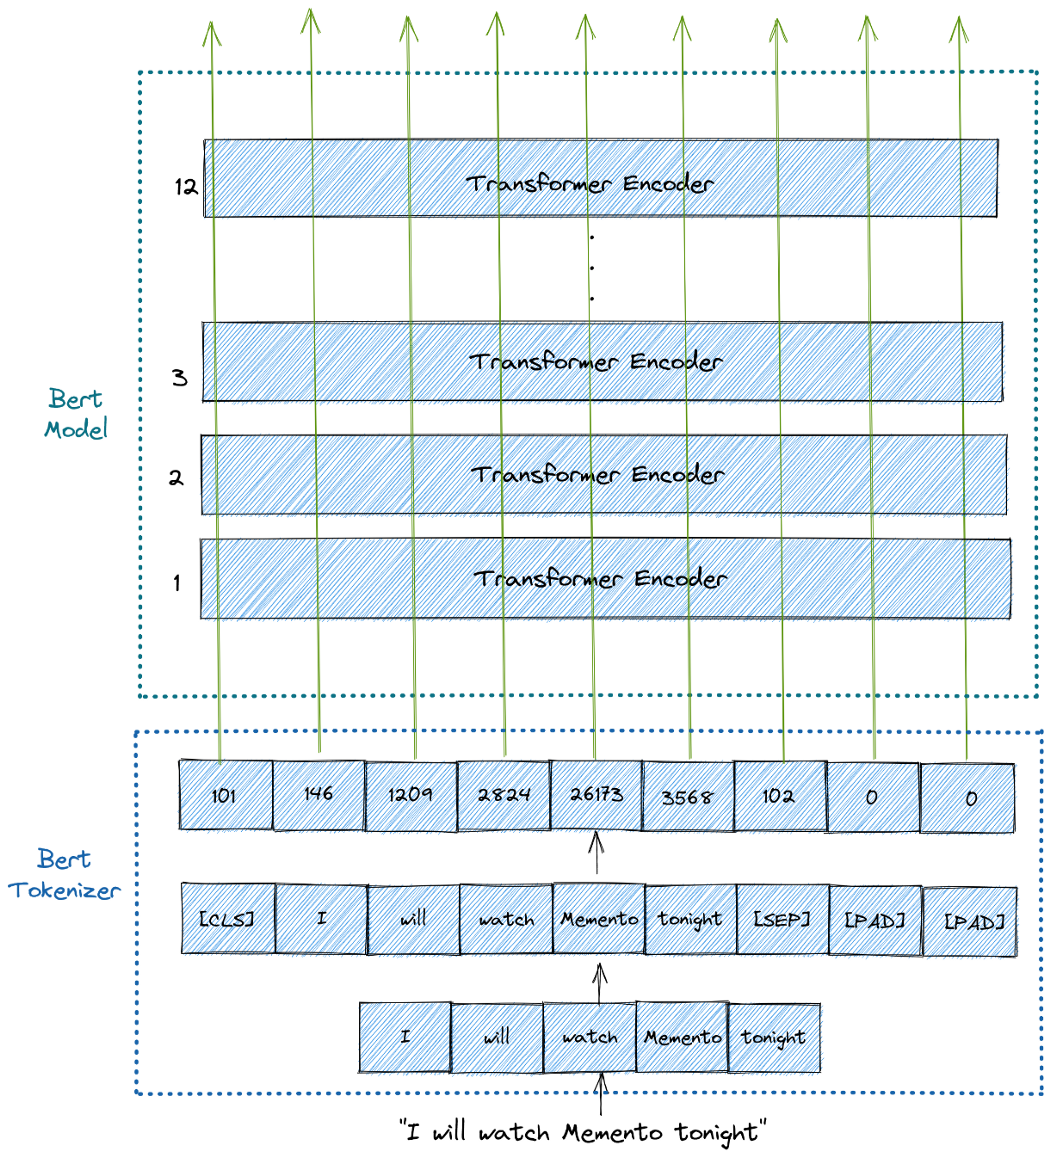

### Creating Dataset:

In [19]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self,X, Y, max_len):
        self.max_len=max_len
        self.labels = Y
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = self.max_len, truncation=True,
                                return_tensors="pt") for text in X]
        
    def classes(self):
        return self.labels
        
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])
    
    
    def get_batch_texts(self, idx):
        return self.texts[idx]
    
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        
        return batch_texts, batch_y
        

In [20]:
train_dataset = Dataset(trainx, trainy,150)

In [21]:
train_dataset.get_batch_labels(0)

array(0)

In [22]:
train_dataset.get_batch_texts(0)['input_ids'][0]

tensor([  101,  2515, 10334,  2031,  6173,  1005,  1055,  2695,  1999,  2029,
         2002,  2056,  2242,  2066,  1000,  1045,  2123,  1005,  1056,  2113,
         2339,  2045,  2024,  2062,  2273,  2084,  2308,  1999,  5499,  3032,
         1012,  2672,  2009,  1005,  1055, 23503,  2015,  4288,  1996,  2931,
         2336,  1000,  1029,  2009,  1005,  1055,  2026,  3167,  5440,   999,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [23]:
tokenizer.decode(train_dataset.get_batch_texts(0)['input_ids'][0])

'[CLS] does anybody have bobby\'s post in which he said something like " i don\'t know why there are more men than women in islamic countries. maybe it\'s atheists killing the female children "? it\'s my personal favorite! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [24]:
trainx[0]

'     \n\nDoes anybody have Bobby\'s post in which he said something like "I don\'t\nknow why there are more men than women in islamic countries. Maybe it\'s\natheists killing the female children"? It\'s my personal favorite!\n'

In [25]:
#encoding['input_ids'][0]

In [26]:
#tokenizer.decode(encoding['input_ids'][0])

In [27]:
test_dataset = Dataset(validx, validy,400)

In [28]:
batch_size=16

In [29]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Building the Model for Transfer Learning

In [35]:
class MyBERTClassifier(nn.Module):
    
    def __init__(self, model, dropout, num_classes):
        super(MyBERTClassifier, self).__init__()
        
        self.bert=model
        self.dropout = nn.Dropout(dropout)
        self.linear=nn.Linear(128, num_classes) ## Use this if you want add one more layer to train
        self.relu=nn.ReLU()
        
        
    def forward(self, input_id, mask):
        _,pooled_output = self.bert(input_ids=input_id, attention_mask=mask,return_dict=False)
        ## _ containes the embeddings and pooled_output is the BERT pooling layer
        relu_layer = self.relu(pooled_output)
        dropout_output = self.dropout(relu_layer)
        linear_output = self.linear(dropout_output) ## Additional trainable linear layer
        final_layer = self.relu(linear_output) 
        ## Note: We are not using sigmoid, since it's a multiclass problem
        return final_layer

In [36]:
mymodel = MyBERTClassifier(model,.2,20)

In [40]:
epochs = 10
learning_rate=.001

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [42]:
for epoch in range(epochs):
    myloss = []
    for text, label in tqdm(train_dataloader):
        mask = text['attention_mask']
        input_id = text['input_ids'].squeeze(1)
        
        output = mymodel(input_id, mask)
        
        batch_loss = criterion(output, label.long())

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        myloss.append(round(batch_loss.item(),5))
    print(f'Epoch {epoch+1} of {epochs}; Mean_Loss =  {round(np.mean(myloss),8)}')

100%|██████████| 250/250 [00:23<00:00, 10.58it/s]


Epoch 1 of 10; Mean_Loss =  2.79613176


100%|██████████| 250/250 [00:23<00:00, 10.60it/s]


Epoch 2 of 10; Mean_Loss =  2.48734932


100%|██████████| 250/250 [00:23<00:00, 10.64it/s]


Epoch 3 of 10; Mean_Loss =  2.2605962


100%|██████████| 250/250 [00:27<00:00,  9.20it/s]


Epoch 4 of 10; Mean_Loss =  2.10216352


100%|██████████| 250/250 [00:36<00:00,  6.90it/s]


Epoch 5 of 10; Mean_Loss =  1.981789


100%|██████████| 250/250 [00:32<00:00,  7.76it/s]


Epoch 6 of 10; Mean_Loss =  1.89876724


100%|██████████| 250/250 [00:51<00:00,  4.90it/s]


Epoch 7 of 10; Mean_Loss =  1.82409332


100%|██████████| 250/250 [00:43<00:00,  5.79it/s]


Epoch 8 of 10; Mean_Loss =  1.78811828


100%|██████████| 250/250 [00:39<00:00,  6.39it/s]


Epoch 9 of 10; Mean_Loss =  1.77887972


100%|██████████| 250/250 [00:39<00:00,  6.38it/s]

Epoch 10 of 10; Mean_Loss =  1.85381136


In [44]:
len(test_dataset)/batch_size

62.5

In [45]:
output=[]
for test_input, test_label in test_dataloader:
            #test_label = test_label.to(device)
            mask = test_input['attention_mask']#.to(device)
            input_id = test_input['input_ids'].squeeze(1)#.to(device)

            output.append(mymodel(input_id, mask))

In [46]:
from sklearn.metrics import roc_auc_score

In [47]:
len(output)

63

In [48]:
len(output[0])

16

In [49]:
len(output[15])

16

In [50]:
64*15 +40

1000

### One Hot Encoding of testY & Preparing the predicted data for AUC calculation

In [51]:
myoutput=[]
with torch.no_grad():
    for i in range(len(output)):
        for j in range(len(output[i])):
            myoutput.append(output[i][j].numpy())
        #myoutput.append(list(output[i].numpy()))
myoutput2=np.stack(myoutput, axis=0)

In [52]:
len(myoutput2)

1000

In [53]:
myoutput2[0]

array([0.8001104 , 0.        , 0.14402354, 0.6169639 , 0.        ,
       0.        , 0.        , 1.5026703 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.18931457,
       0.02412599, 1.2349203 , 0.        , 0.3456192 , 0.5646311 ],
      dtype=float32)

In [54]:
myoutput2_df=pd.DataFrame(myoutput2)

In [55]:
myoutput2_df.head(2)

0    1         2         3    4         5    6        7    8    9   \
0  0.80011  0.0  0.144024  0.616964  0.0  0.000000  0.0  1.50267  0.0  0.0   
1  0.00000  0.0  0.339343  0.000000  0.0  0.097384  0.0  0.00000  0.0  0.0   

         10        11        12   13        14        15        16   17  \
0  0.000000  0.000000  0.000000  0.0  0.189315  0.024126  1.234920  0.0   
1  0.262163  2.525116  0.278539  0.0  0.000000  0.000000  0.317206  0.0   

         18        19  
0  0.345619  0.564631  
1  0.567688  0.647402

In [56]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

In [57]:
validy_df = pd.DataFrame(validy, columns=['target_label'])

In [58]:
encoder_df = pd.DataFrame(one_hot_encoder.fit_transform(validy_df).toarray())

In [59]:
encoder_df.head(2)

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14  \
0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   

    15   16   17   18   19  
0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0

#### The model has performed quite good when we had less data (only 4k to train) over 20 classes!

In [72]:
auc_score = round(roc_auc_score(encoder_df,myoutput2_df, multi_class='ovr', average='weighted'),2) 
print(f'Average OVR-(One v/s Rest) ACR is {auc_score}')

Average OVR-(One v/s Rest) ACR is 0.79


### Compare the weights of any encoding layer before and after training to see if actually those layers were frozen ?